# Task 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model  import LinearRegression
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

In [113]:
df = pd.read_csv("credit_cleaned.csv")

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     310 non-null    float64
 1   Limit      310 non-null    int64  
 2   Rating     310 non-null    int64  
 3   Cards      310 non-null    int64  
 4   Age        310 non-null    int64  
 5   Education  310 non-null    int64  
 6   Gender     310 non-null    int64  
 7   Student    310 non-null    int64  
 8   Married    310 non-null    int64  
 9   Ethnicity  310 non-null    int64  
 10  Balance    310 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 26.8 KB


## 1. relevant features

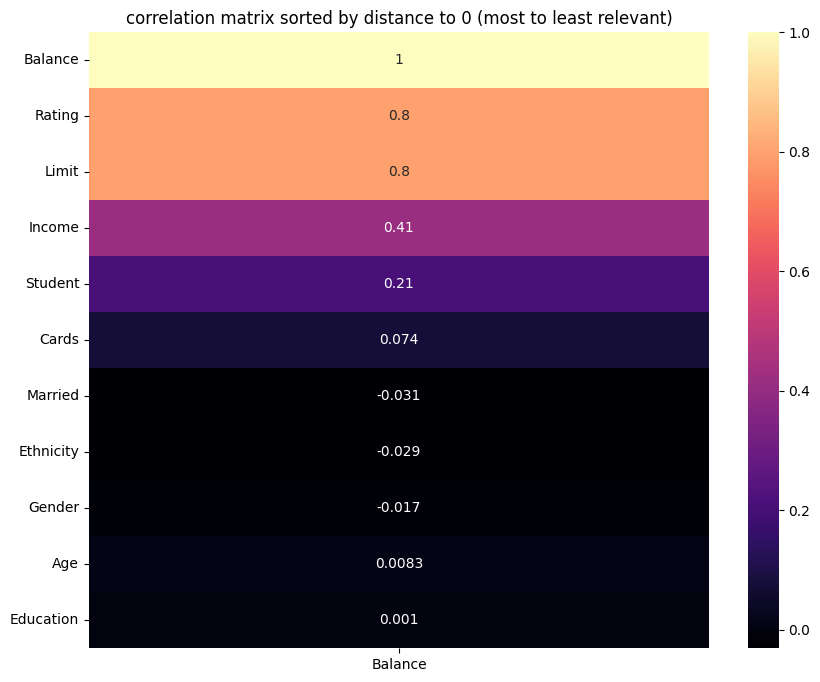

In [115]:
target_corr = df.corr()[["Balance"]].copy()
target_corr["abs_corr"] = target_corr["Balance"].abs()
target_corr = target_corr.sort_values(by="abs_corr", ascending=False)
relevant = []
[relevant.append(feature) for feature in target_corr.index if target_corr.loc[feature, "abs_corr"] > 0.1]
target_corr = target_corr[["Balance"]]
plt.figure(figsize=(10,8))
plt.title("correlation matrix sorted by distance to 0 (most to least relevant)")
sns.heatmap(target_corr, cmap="magma", annot=True)
plt.savefig("Correlation matrix to 0.png")

In [116]:
relevant
relevant_df= df[relevant]
relevant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Balance  310 non-null    int64  
 1   Rating   310 non-null    int64  
 2   Limit    310 non-null    int64  
 3   Income   310 non-null    float64
 4   Student  310 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 12.2 KB


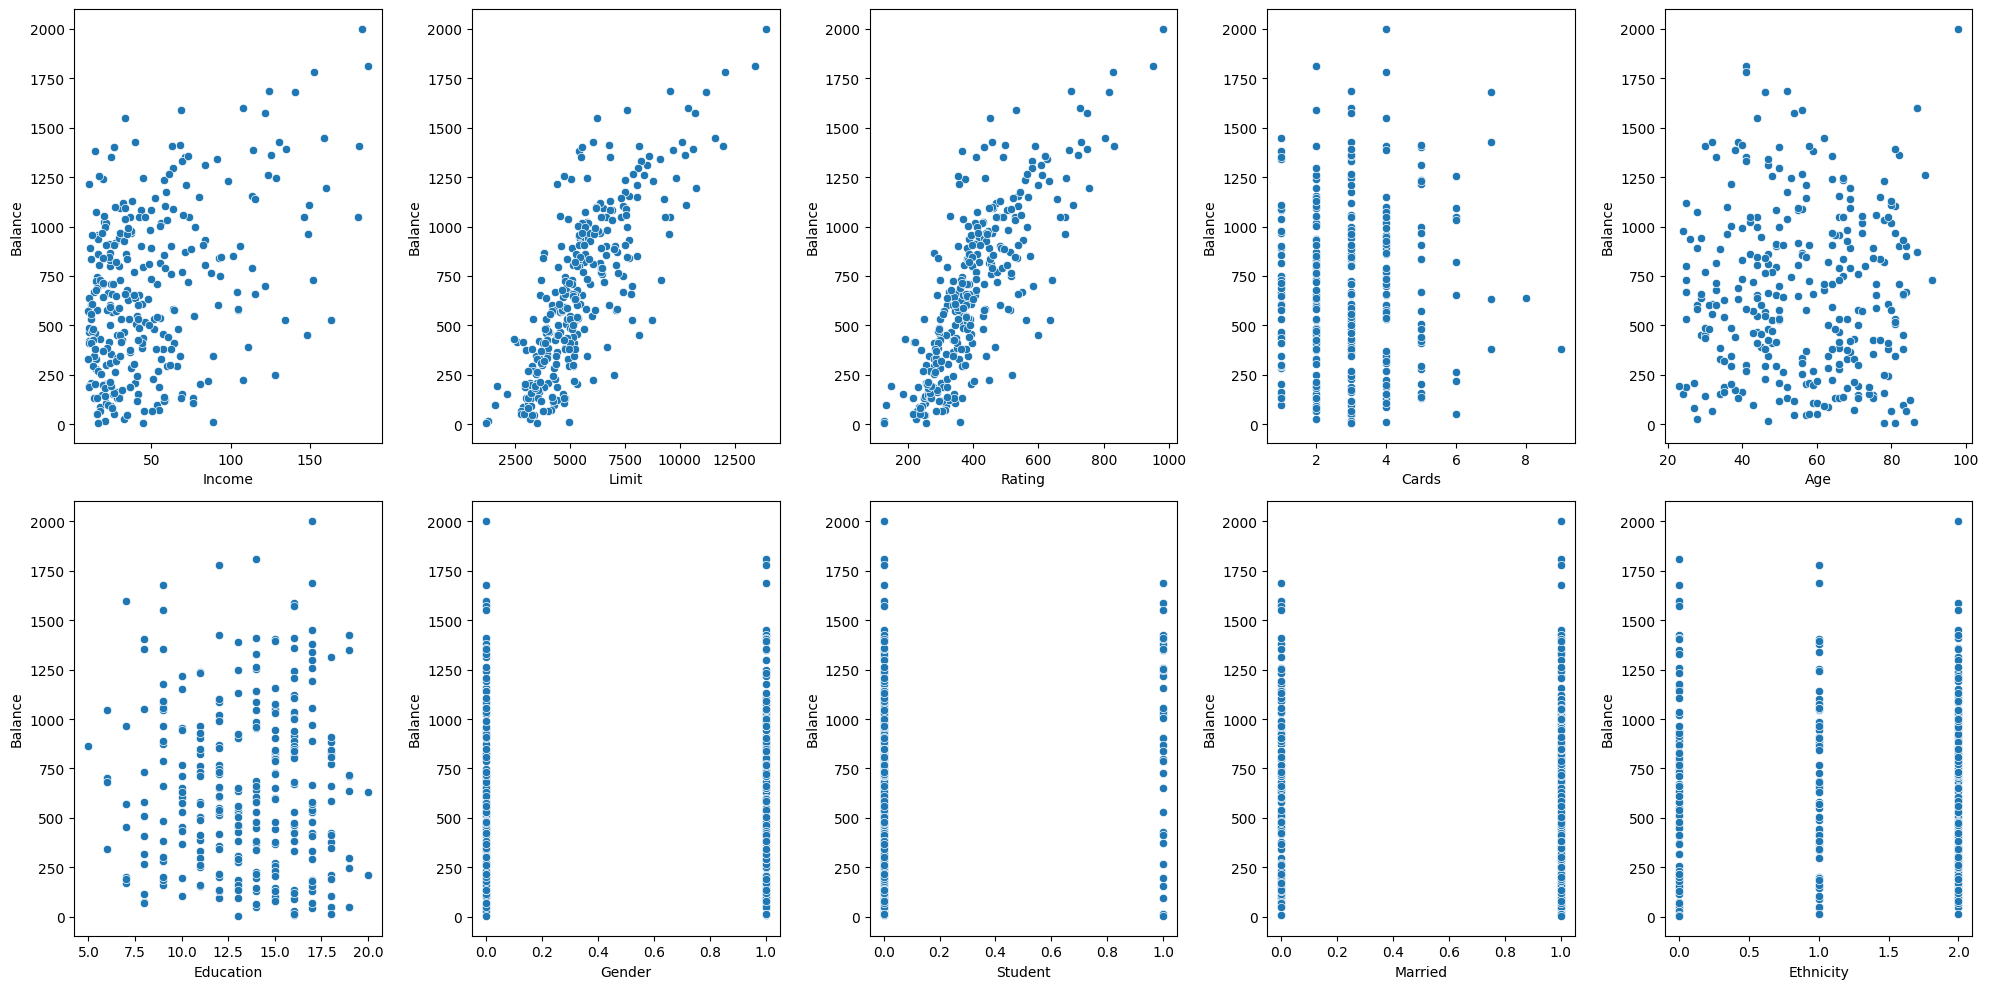

In [117]:
features = df.columns[:-1]
features_per_row = 5
num_rows = (len(features) + features_per_row - 1) // features_per_row
fig, axes = plt.subplots(num_rows, features_per_row, figsize=(20, num_rows * 5))

for i, feature in enumerate(features):
    row = i // features_per_row
    col = i % features_per_row
    sns.scatterplot(x=df[feature], y=df['Balance'], ax=axes[row][col])
    axes[row][col].set_xlabel(feature)
    axes[row][col].set_ylabel('Balance')

# Leere Subplots entfernen
for j in range(i + 1, num_rows * features_per_row):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.savefig("Correlation between Balance and other features.png")

## 2. linear regression

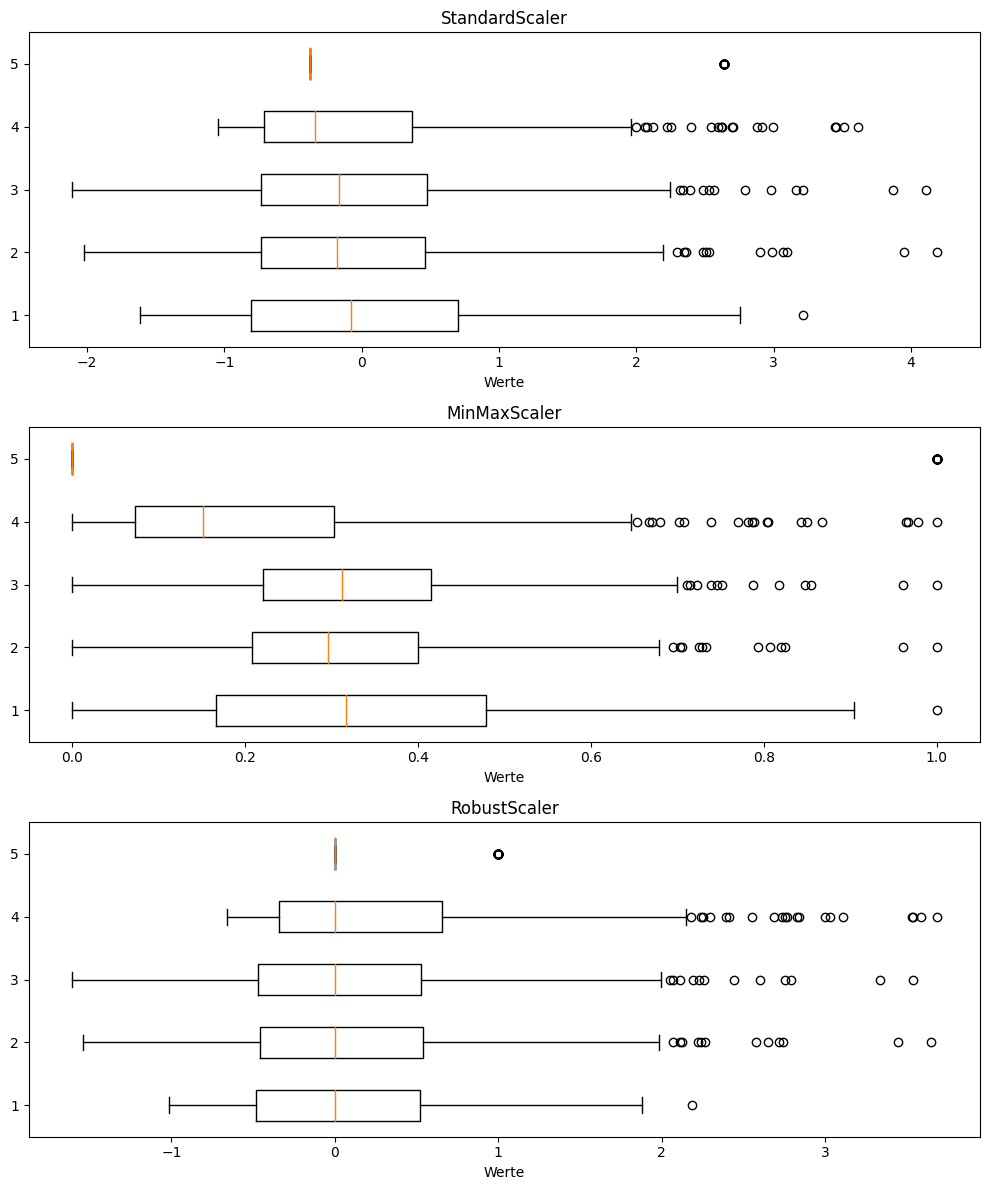

StandardScaler Mittelwert und Std.:
Balance   -1.719055e-17
Rating    -6.016693e-17
Limit     -2.865092e-18
Income    -1.002782e-17
Student    8.308766e-17
dtype: float64 Balance    1.001617
Rating     1.001617
Limit      1.001617
Income     1.001617
Student    1.001617
dtype: float64

MinMaxScaler Mittelwert und Std.:
Balance    0.333996
Rating     0.325995
Limit      0.339173
Income     0.224783
Student    0.125806
dtype: float64 Balance    0.207575
Rating     0.161177
Limit      0.160939
Income     0.214895
Student    0.332167
dtype: float64

RobustScaler Mittelwert und Std.:
Balance    0.053773
Rating     0.151828
Limit      0.136644
Income     0.316280
Student    0.125806
dtype: float64 Balance    0.664639
Rating     0.836166
Limit      0.828604
Income     0.933275
Student    0.332167
dtype: float64


In [119]:
stand_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Skalierung mit StandardScaler
stand_scaled_df = pd.DataFrame(stand_scaler.fit_transform(relevant_df.select_dtypes(include=["float64", "int64"])))
stand_scaled_df.columns = relevant_df.select_dtypes(include=["float64", "int64"]).columns

# Skalierung mit MinMaxScaler
minmax_scaled_df = pd.DataFrame(minmax_scaler.fit_transform(relevant_df.select_dtypes(include=["float64", "int64"])))
minmax_scaled_df.columns = relevant_df.select_dtypes(include=["float64", "int64"]).columns

# Skalierung mit RobustScaler
robust_scaled_df = pd.DataFrame(robust_scaler.fit_transform(relevant_df.select_dtypes(include=["float64", "int64"])))
robust_scaled_df.columns = relevant_df.select_dtypes(include=["float64", "int64"]).columns

# Vergleiche die Verteilungen der drei Skaler (z.B. durch Plots)
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Verteilung nach StandardScaler
axes[0].boxplot(stand_scaled_df, vert=False)
axes[0].set_title("StandardScaler")
axes[0].set_xlabel("Werte")

# Verteilung nach MinMaxScaler
axes[1].boxplot(minmax_scaled_df, vert=False)
axes[1].set_title("MinMaxScaler")
axes[1].set_xlabel("Werte")

# Verteilung nach RobustScaler
axes[2].boxplot(robust_scaled_df, vert=False)
axes[2].set_title("RobustScaler")
axes[2].set_xlabel("Werte")

plt.tight_layout()
plt.show()

# Optional: Berechne den Mittelwert und die Standardabweichung der skalierten Werte
print("StandardScaler Mittelwert und Std.:")
print(stand_scaled_df.mean(), stand_scaled_df.std())

print("\nMinMaxScaler Mittelwert und Std.:")
print(minmax_scaled_df.mean(), minmax_scaled_df.std())

print("\nRobustScaler Mittelwert und Std.:")
print(robust_scaled_df.mean(), robust_scaled_df.std())


mean_mse: -1367.2690225433525
std_mse: 249.36944585528482


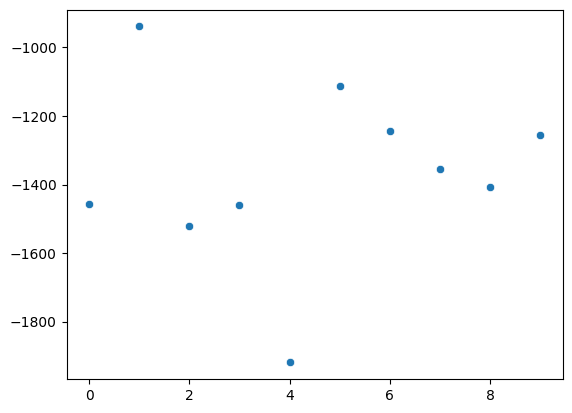

In [ ]:
X = relevant_df.drop(columns=["Balance"])
y = relevant_df["Balance"]
lr = LinearRegression()

for 
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = np.mean(np.abs(cv_scores))
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
train_error = mean_squared_error(y_train, y_train_pred)
y_test_pred = model.predict(X_test)
test_error = mean_squared_error(y_test, y_test_pred)

sp = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_score = cross_val_score(lr, X, y, cv=10, scoring="neg_mean_squared_error")
sns.scatterplot(cv_score)
print(f"mean_mse: {cv_score.mean()}\nstd_mse: {cv_score.std()}")

- _standard scaling_: converts  features to standard normal variables
- _min-max scaling_: converts variables to continuous variables in the (0, 1) interval by mapping minimum values to 0 and maximum values to 1 -> sensitiv to outliers!
- _robust scaling_: is similar to min-max, but instead maps the _interquartile range_ (75th percentile value -  25th percentile value) to (0, 1) -> variables itself takes values outside of the (0, 1) interval

1. StandardScaler
    - Mean: all averages are near 0, which was expected based on the mathematical calculation (can be considerd rounding error)
    - Standard deviation: all stds are close to 1, which is also expected, this means the dispersion of the values after scaling is the same
    - Standardscaler has successfully transformed the data so that it has mean of 0 and a std of 1, which is especially useful for algorithms such as linear regression or SVMs based on normalized data
2. MinMaxScaler
    - Mean: averages range from 0.126 (for Student columns) to 0.340 (for Limit) -> range between 0 and 1 and the mean fo each column is a kind of "average position" in the scale range
    - Standard deviation: the largest std ist 0.332 (for Student) and the smallest is 0.126 (for student)
    - MinMaxScaler scales data to range [0,1], but the distibution of values (the spread) vaires dependig on the column
    - useful when data is known to have a range that is required by algorithms such as KNN or SVMs that are sensitive to the scale
3. RobustScaler
    - Mean: in a range of 0.054 to 0.316, changes the scale less than Standard and MinMax because it is based on median and IQR instead of mean and std
    - Standard deviation: wide range from 0.665 to 0.933, more robust to outliers
    - more robust to outliers and especially helpful
   

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Beispiel mit StandardScaler:
X_train_scaled = stand_scaler.fit_transform(X_train)
X_test_scaled = stand_scaler.transform(X_test)

# Trainiere das Modell auf den skalierten Trainingsdaten
lr.fit(X_train_scaled, y_train)

# Vorhersage und MSE für den Testdatensatz
y_pred = lr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"Mittlere quadratische Fehler (MSE) für das Testset (StandardScaler): {mse:.4f}")
   

Mittlere quadratische Fehler (MSE) für das Testset (StandardScaler): 1163.6672
